In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings('ignore')

c:\Users\user\.virtualenvs\habi_ia-jg5KU8bY\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
habi_df = pd.read_excel('dataset.xlsx')

In [3]:
habi_df.head()

,id,birth_date,terms_conditions,gender,meta,date_exp_token,id.1,contact_id,type_occupation_id,type_independent_activity_id,...,company_phone,company_city_id,name,label,is_active,activity_code,name.1,label.1,viability,is_selected
0,1767,1998-05-30,1,NaN,NaN,2022-11-25 23:13:29.0,5,1767,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,0
1,1767,1998-05-30,1,NaN,NaN,2022-11-25 23:13:29.0,5,1767,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,0,0
2,23963,1984-07-08,0,NaN,NaN,2023-01-16 18:16:50.0,4547,23963,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1
3,23965,1985-02-14,0,NaN,NaN,NaN,4549,23965,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1
4,24370,1997-01-09,0,NaN,NaN,NaN,4860,24370,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1


In [4]:
habi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3944 entries, 0 to 3943
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            3944 non-null   int64  
 1   birth_date                    3900 non-null   object 
 2   terms_conditions              3944 non-null   int64  
 3   gender                        2 non-null      object 
 4   meta                          16 non-null     object 
 5   date_exp_token                2351 non-null   object 
 6   id.1                          3944 non-null   int64  
 7   contact_id                    3944 non-null   int64  
 8   type_occupation_id            3944 non-null   int64  
 9   type_independent_activity_id  3944 non-null   int64  
 10  type_profession_id            2 non-null      float64
 11  type_contract_id              0 non-null      float64
 12  init_occupation_date          2 non-null      object 
 13  inc

<Axes: >

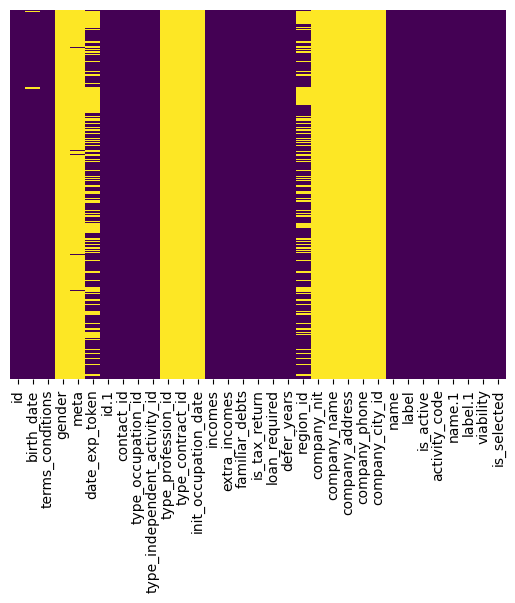

In [5]:
sns.heatmap(habi_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

No son utiles: 
gender
meta
type_profession_id
type_contract_id
init_occupation_date
company_nit
company_name
company_address
company_phone
company_city_id

In [6]:
habi_df.columns

Index(['id', 'birth_date', 'terms_conditions', 'gender', 'meta',
       'date_exp_token', 'id.1', 'contact_id', 'type_occupation_id',
       'type_independent_activity_id', 'type_profession_id',
       'type_contract_id', 'init_occupation_date', 'incomes', 'extra_incomes',
       'familiar_debts', 'is_tax_return', 'loan_required', 'defer_years',
       'region_id', 'company_nit', 'company_name', 'company_address',
       'company_phone', 'company_city_id', 'name', 'label', 'is_active',
       'activity_code', 'name.1', 'label.1', 'viability', 'is_selected'],
      dtype='object')

In [7]:
ids_columns = ['id','id.1','loan_required','defer_years']
null_columns = ["gender",
    "meta",
    "type_profession_id",
    "type_contract_id",
    "init_occupation_date",
    "company_nit",
    "company_name",
    "company_address",
    "company_phone",
    "company_city_id"
    ]

habi_df = habi_df.drop(columns=ids_columns+null_columns)

# Verificar valores nulos 

<Axes: >

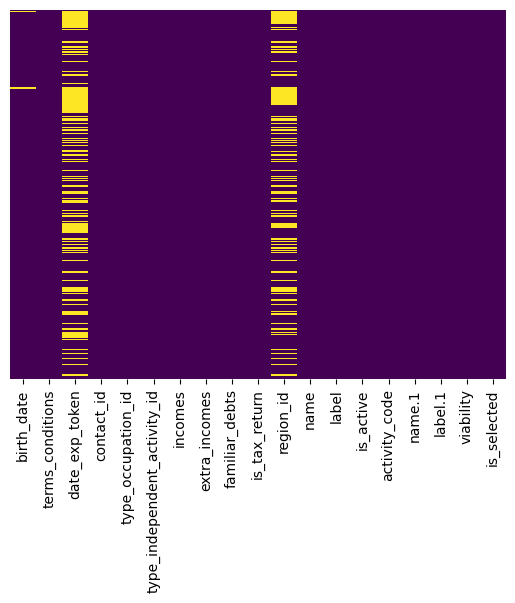

In [8]:
sns.heatmap(habi_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [9]:
habi_df.head()

,birth_date,terms_conditions,date_exp_token,contact_id,type_occupation_id,type_independent_activity_id,incomes,extra_incomes,familiar_debts,is_tax_return,region_id,name,label,is_active,activity_code,name.1,label.1,viability,is_selected
0,1998-05-30,1,2022-11-25 23:13:29.0,1767,1,1,1500000,700000,0,0,26.0,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,0
1,1998-05-30,1,2022-11-25 23:13:29.0,1767,1,1,1500000,700000,0,0,26.0,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,0,0
2,1984-07-08,0,2023-01-16 18:16:50.0,23963,1,1,4781830,0,0,1,1.0,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1
3,1985-02-14,0,NaN,23965,1,1,9000000,1000000,0,1,11.0,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1
4,1997-01-09,0,NaN,24370,1,1,8000000,0,0,1,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1


In [10]:
habi_df[['name','label']].groupby(['name','label']).size() 

name                                               label                                             
agriculture, livestock, hunting, forestry fishing  Agricultura, Ganadería, Caza, Silvicultura y Pesca      66
association and repair activities                  Actividades de Asociación y Reparación                  47
manufacture                                        Industrias Manufactureras                              130
other personal services activities                 Otras Actividades de Servicios Personales              537
others                                             Otros                                                 1244
professional scientif and technical activities     Actividades Profesionales, Ciéntificas y Técnicas      777
real state activitys                               Actividades Inmobiliarias                              189
transport and storage                              Transporte y Almacenamiento                            169
wholesale and reta

In [11]:
habi_df[['name.1','label.1']].groupby(['name.1','label.1']).size() 


name.1       label.1      
employee     Asalariado        118
independent  Independiente    3825
retired      Pensionado          1
dtype: int64

In [12]:
repeated_columns = ["label",  'label.1' ]
habi_df = habi_df.drop(columns=repeated_columns)

* el dataset es inbalanceado

In [13]:
habi_df['viability'].value_counts()

viability
1    2698
0    1246
Name: count, dtype: int64

In [14]:
habi_df.head()

,birth_date,terms_conditions,date_exp_token,contact_id,type_occupation_id,type_independent_activity_id,incomes,extra_incomes,familiar_debts,is_tax_return,region_id,name,is_active,activity_code,name.1,viability,is_selected
0,1998-05-30,1,2022-11-25 23:13:29.0,1767,1,1,1500000,700000,0,0,26.0,"wholesale and retail, auto repair",1,3,employee,1,0
1,1998-05-30,1,2022-11-25 23:13:29.0,1767,1,1,1500000,700000,0,0,26.0,"wholesale and retail, auto repair",1,3,employee,0,0
2,1984-07-08,0,2023-01-16 18:16:50.0,23963,1,1,4781830,0,0,1,1.0,"wholesale and retail, auto repair",1,3,employee,1,1
3,1985-02-14,0,NaN,23965,1,1,9000000,1000000,0,1,11.0,"wholesale and retail, auto repair",1,3,employee,1,1
4,1997-01-09,0,NaN,24370,1,1,8000000,0,0,1,NaN,"wholesale and retail, auto repair",1,3,employee,1,1


In [15]:
habi_df = habi_df[~habi_df.birth_date.isnull()]

# Feature Engineering

In [16]:
habi_df['has_extra_incomes'] = (habi_df.extra_incomes==0).astype(int)
habi_df['has_familiar_debts'] = (habi_df.familiar_debts==0).astype(int)
habi_df['has_region_id'] = ~habi_df.region_id.isnull()
habi_df['has_date_exp_token'] = ~habi_df.date_exp_token.isnull()

In [17]:
habi_df['date_exp_token'] = habi_df['date_exp_token'].fillna(method='ffill')
habi_df['region_id'] = habi_df['region_id'].fillna(0).astype(str)

## Extract time data

In [18]:
habi_df['birth_date'] = pd.to_datetime(habi_df['birth_date'],format='mixed',errors='coerce')
habi_df['birth_date'] = habi_df['birth_date'].fillna(habi_df['birth_date'].median())

In [19]:
habi_df['year_exp_token'] = pd.to_datetime(habi_df['date_exp_token']).dt.year
habi_df['month_exp_token'] = pd.to_datetime(habi_df['date_exp_token']).dt.month
habi_df['day_exp_token'] = pd.to_datetime(habi_df['date_exp_token']).dt.day

habi_df['year_birth'] = pd.to_datetime(habi_df['birth_date']).dt.year
habi_df['month_birth'] = pd.to_datetime(habi_df['birth_date']).dt.month
habi_df['day_birth'] = pd.to_datetime(habi_df['birth_date']).dt.day

habi_df = habi_df.drop(columns=['birth_date','date_exp_token'])

<Axes: >

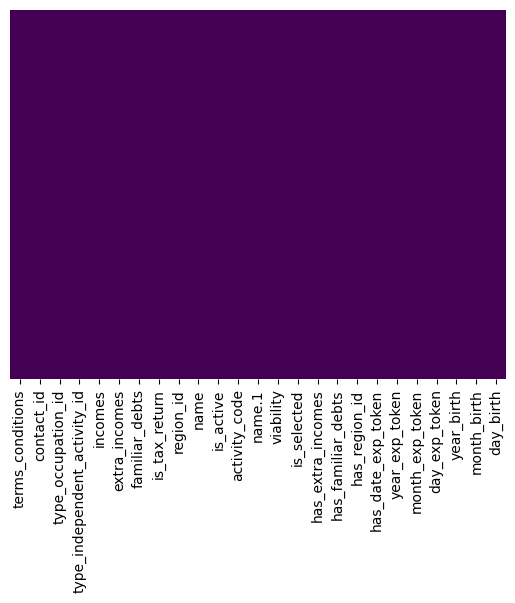

In [20]:
sns.heatmap(habi_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# Undersampling

In [21]:
habi_df = habi_df.sample(frac=1,random_state=44)

# amount of fraud classes 492 rows.
viability_df = habi_df.loc[habi_df['viability'] == 1][:1246]
non_viability_df = habi_df.loc[habi_df['viability'] == 0]

normal_distributed_df = pd.concat([viability_df, non_viability_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,terms_conditions,contact_id,type_occupation_id,type_independent_activity_id,incomes,extra_incomes,familiar_debts,is_tax_return,region_id,name,...,has_extra_incomes,has_familiar_debts,has_region_id,has_date_exp_token,year_exp_token,month_exp_token,day_exp_token,year_birth,month_birth,day_birth
284,1,22942,3,1,10000000,0,0,1,6.0,"wholesale and retail, auto repair",...,1,1,True,True,2022,11,24,1982,10,23
58,1,14291,3,1,2800000,0,1000000,0,13.0,"wholesale and retail, auto repair",...,1,0,True,False,2023,4,5,1990,1,20
169,1,15943,3,1,25000000,0,0,1,2.0,"wholesale and retail, auto repair",...,1,1,True,False,2023,4,28,1996,3,13
141,1,15093,3,1,15000000,0,1500000,1,0.0,"wholesale and retail, auto repair",...,1,0,False,False,2023,4,5,1979,5,13
1618,1,27450,3,2,27000000,0,0,0,1.0,others,...,1,1,True,True,2023,3,6,1960,1,22


Distribution of the Classes in the subsample dataset
viability
1    0.502622
0    0.497378
Name: count, dtype: float64


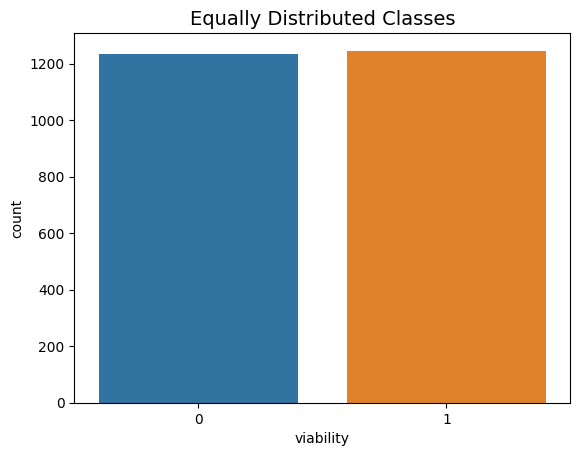

In [22]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['viability'].value_counts()/len(new_df))



sns.countplot(x='viability', data=new_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [23]:
habi_df.columns

Index(['terms_conditions', 'contact_id', 'type_occupation_id',
       'type_independent_activity_id', 'incomes', 'extra_incomes',
       'familiar_debts', 'is_tax_return', 'region_id', 'name', 'is_active',
       'activity_code', 'name.1', 'viability', 'is_selected',
       'has_extra_incomes', 'has_familiar_debts', 'has_region_id',
       'has_date_exp_token', 'year_exp_token', 'month_exp_token',
       'day_exp_token', 'year_birth', 'month_birth', 'day_birth'],
      dtype='object')

In [25]:
habi_df.to_excel('clean.xlsx',index=None)


In [24]:

def proba_plot(df:pd.DataFrame,feature:str):
    probabilities = df.groupby([feature, 'viability']).size() / df.groupby(feature).size()
    probabilities = probabilities.reset_index().rename(columns={0: 'Probability'})
    pivot_df = probabilities.pivot(index=feature, columns='viability', values='Probability')
    pivot_df.plot(kind='bar', stacked=False)
    plt.title('Probabilities of Class Combinations')
    plt.xlabel(feature)
    plt.ylabel('Probability')
    plt.show()

terms_conditions


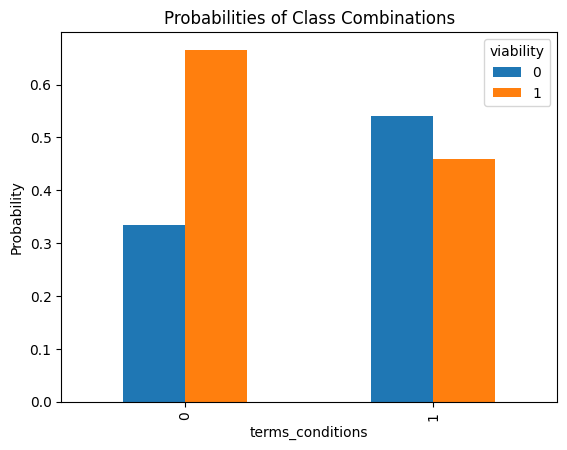

type_occupation_id


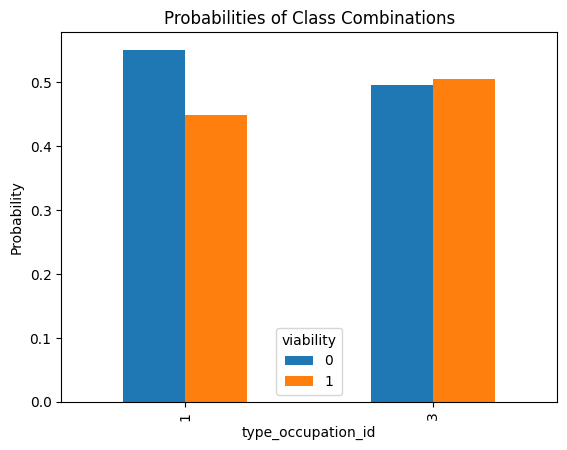

type_independent_activity_id


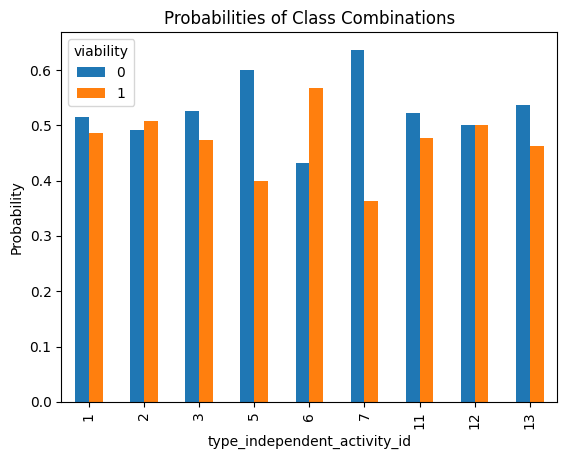

is_tax_return


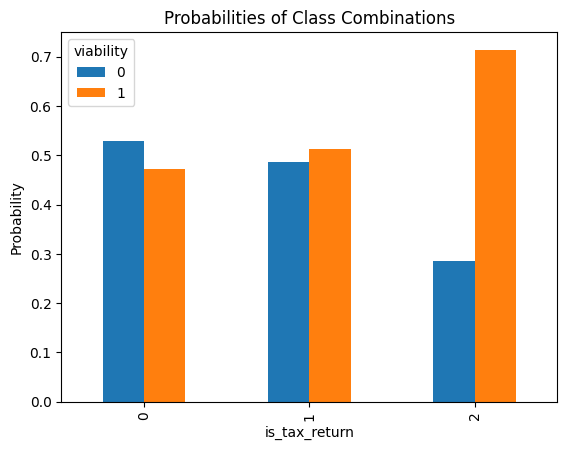

region_id


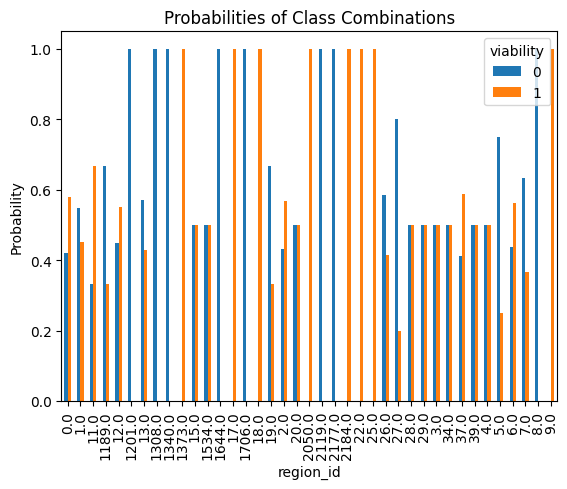

name


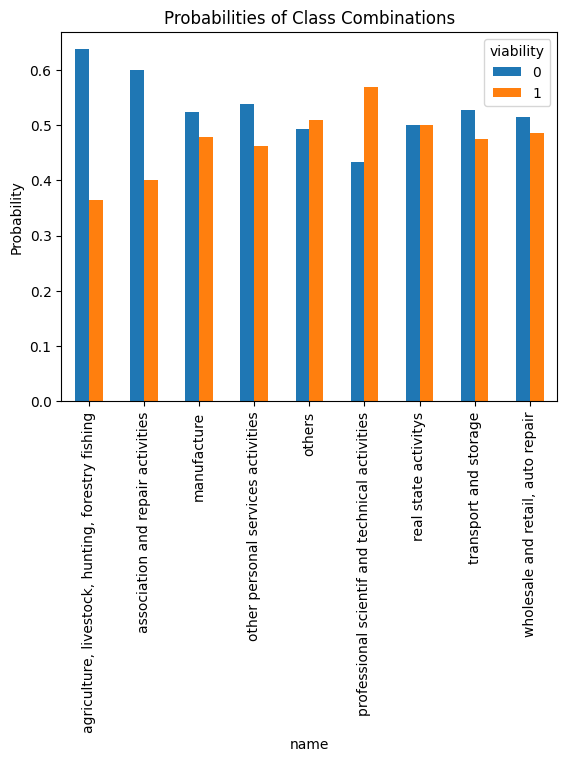

is_active


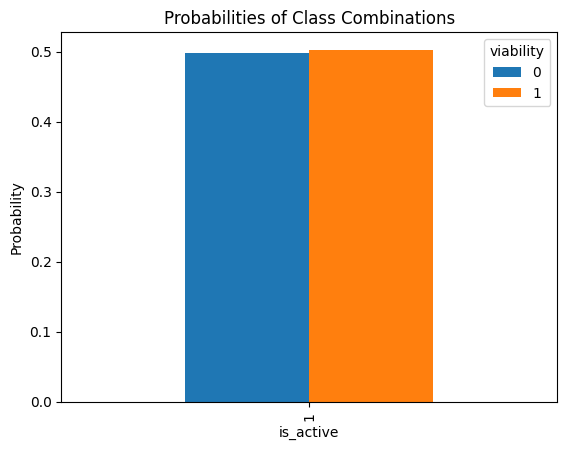

activity_code


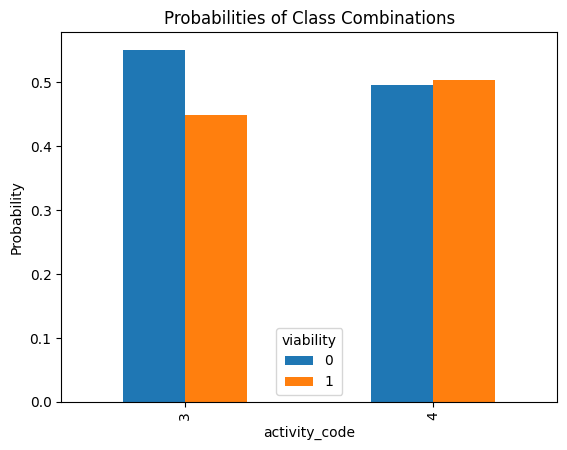

name.1


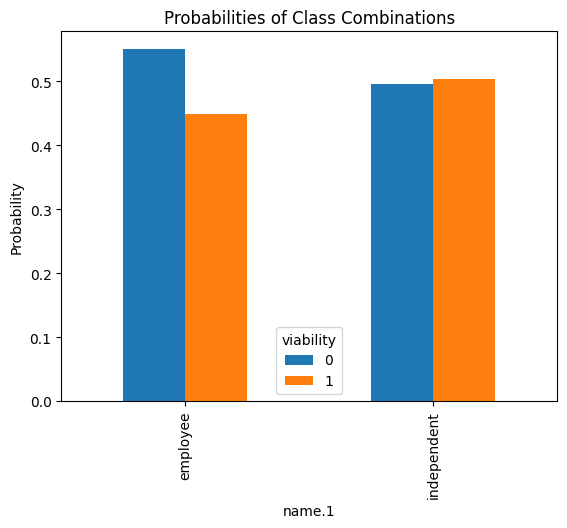

is_selected


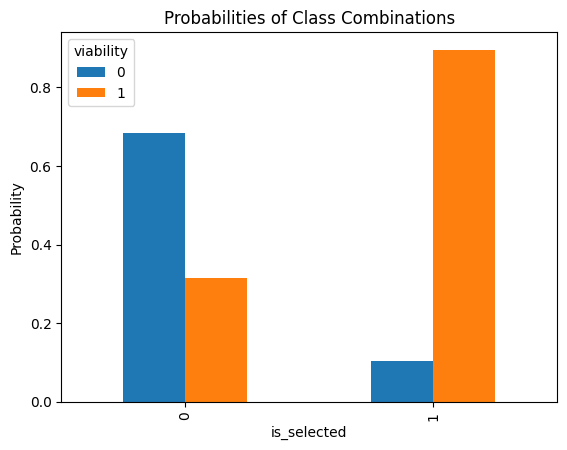

has_extra_incomes


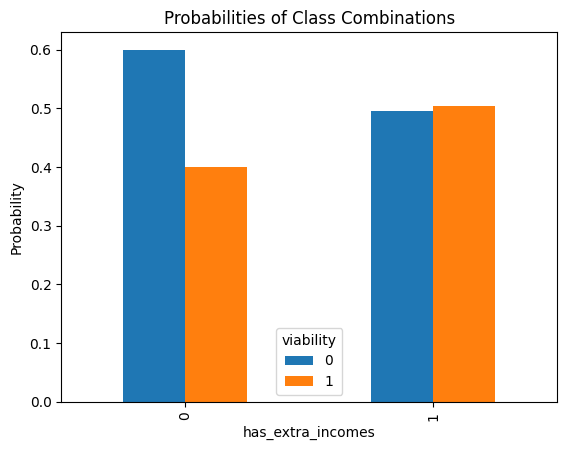

has_familiar_debts


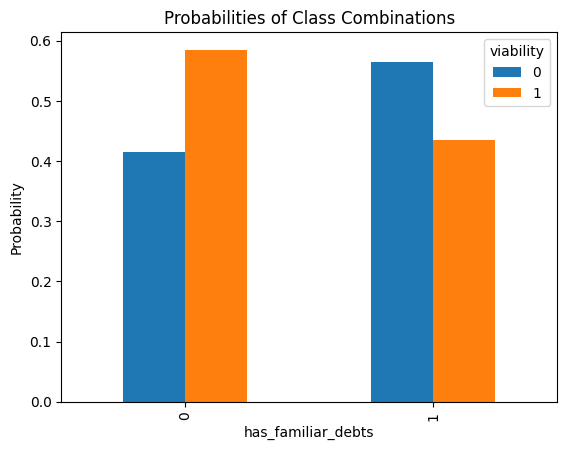

has_region_id


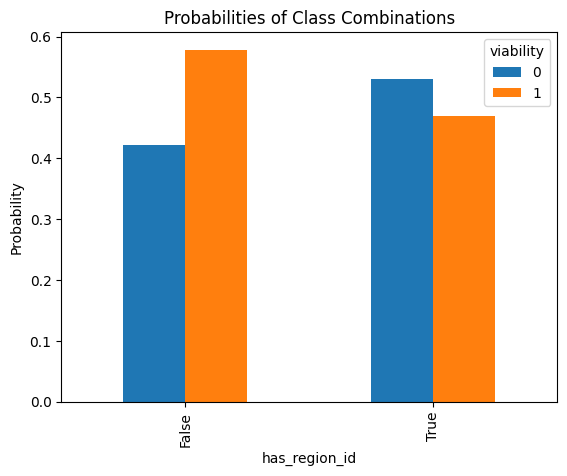

has_date_exp_token


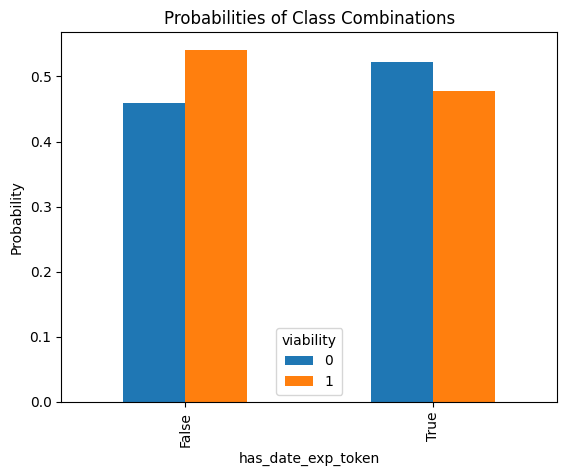

year_exp_token


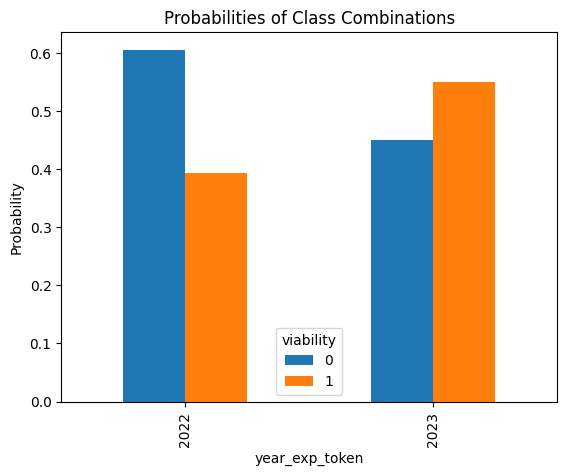

month_exp_token


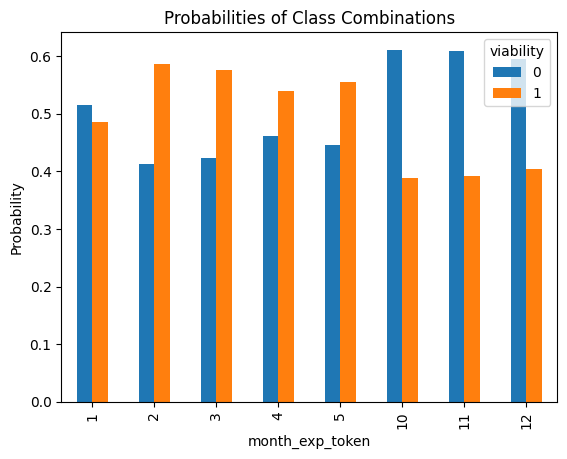

day_exp_token


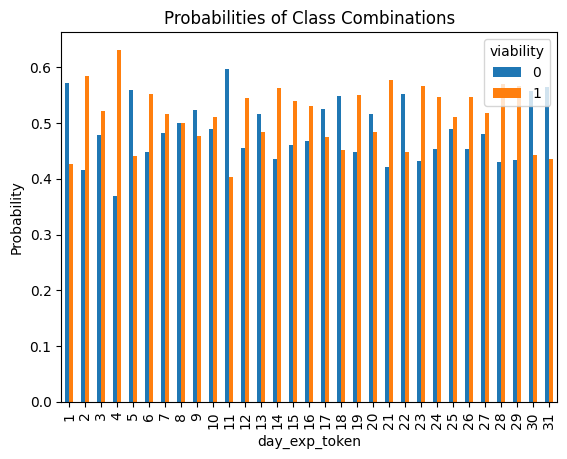

year_birth


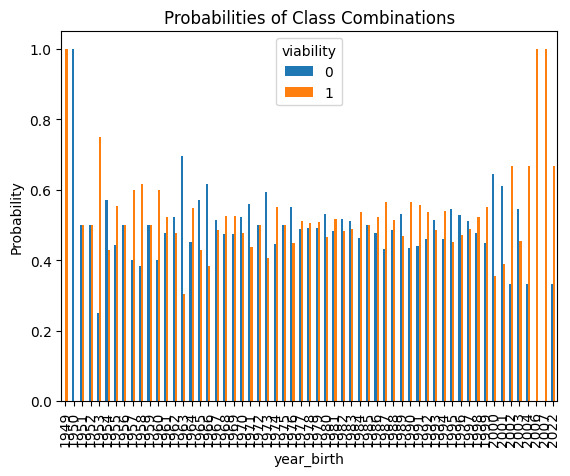

month_birth


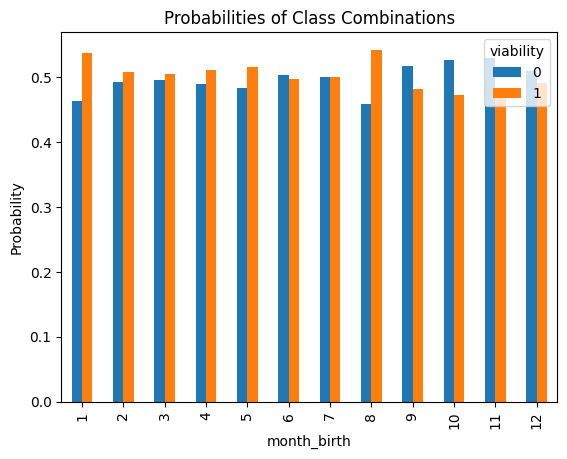

day_birth


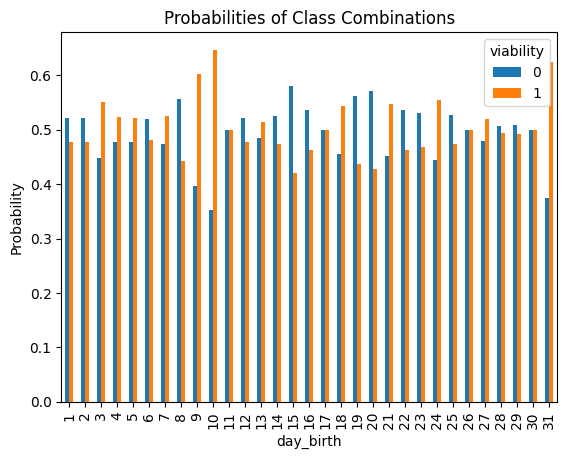

In [27]:
categorical = ['terms_conditions', 'type_occupation_id',
       'type_independent_activity_id',  'is_tax_return', 'region_id', 'name', 'is_active',
       'activity_code', 'name.1', 'is_selected',
       'has_extra_incomes', 'has_familiar_debts', 'has_region_id',
       'has_date_exp_token', 'year_exp_token', 'month_exp_token',
       'day_exp_token', 'year_birth', 'month_birth', 'day_birth']

for c in categorical:
    print(c)
    proba_plot(new_df,c)

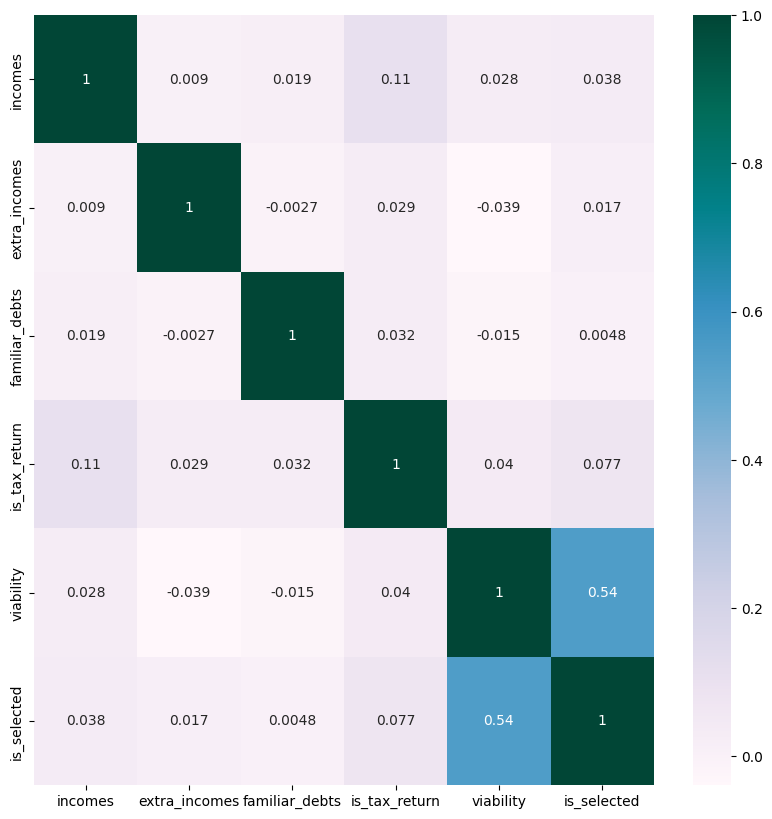

In [28]:
plt.figure(figsize=(10,10))
plt.rc('font', size=10)
hm=sns.heatmap((new_df[['incomes','extra_incomes','familiar_debts','is_tax_return','viability','is_selected']].corr()),cmap="PuBuGn",annot=True)

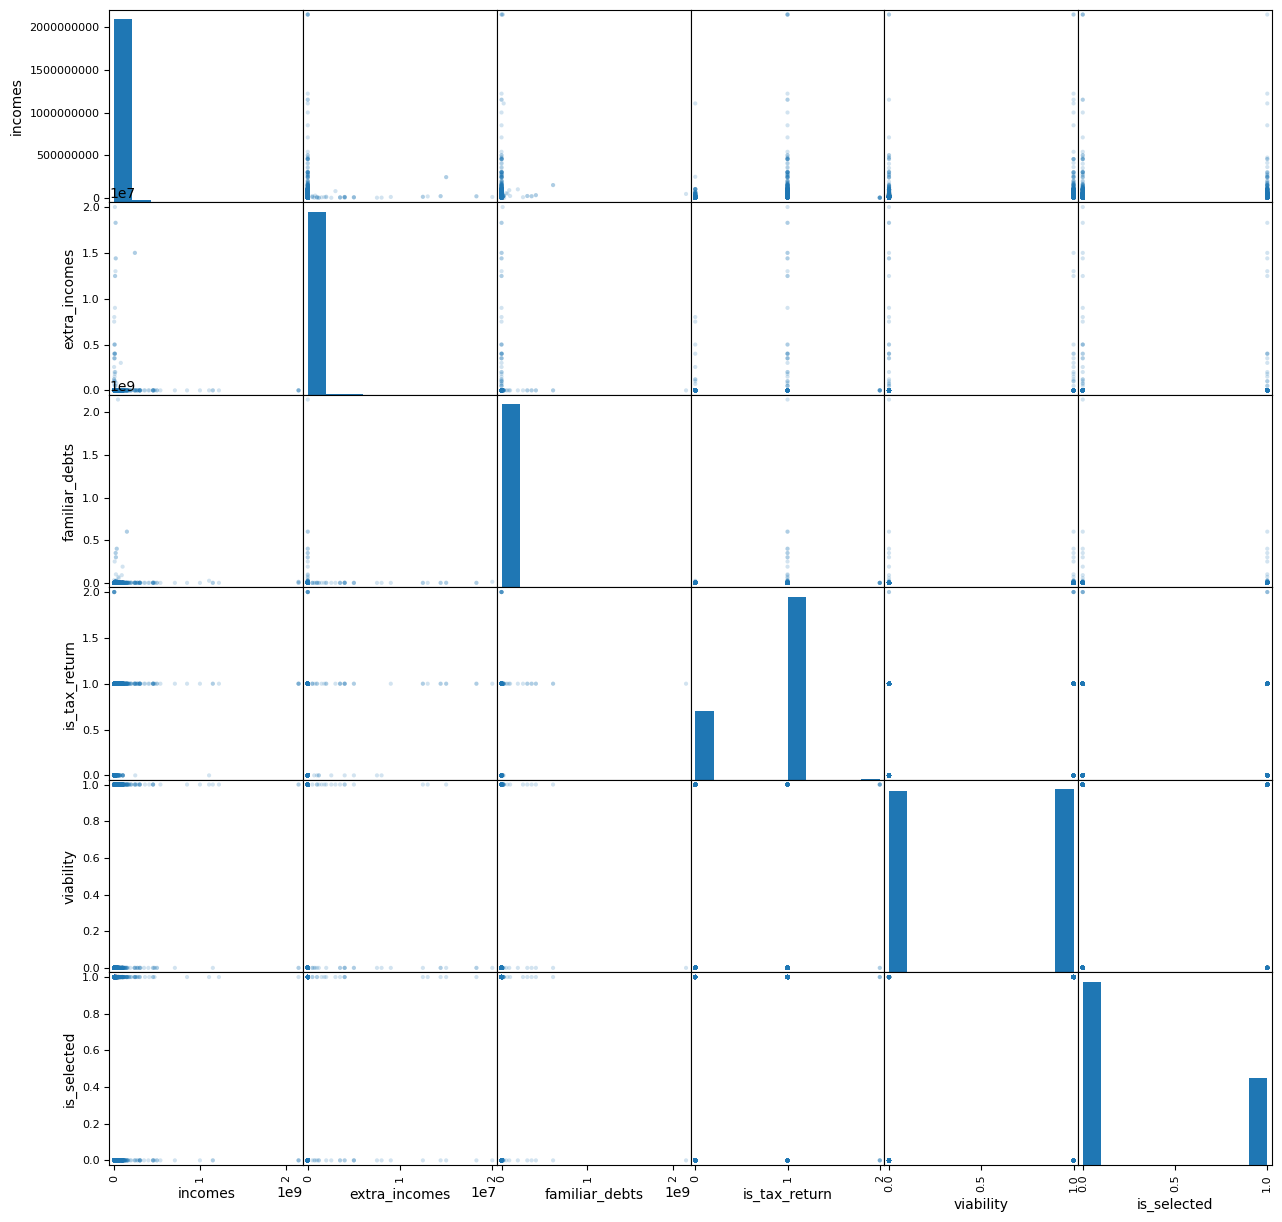

In [29]:
pd.plotting.scatter_matrix(new_df[['incomes','extra_incomes','familiar_debts','is_tax_return','viability','is_selected']], alpha=0.2,figsize=(15,15))
print()

In [30]:
from sklearn.metrics import mutual_info_score

def mutual_info_churn_score(series):
    return mutual_info_score(series,new_df['viability'])


mi = new_df[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

is_selected                     0.163154
region_id                       0.016485
terms_conditions                0.014120
month_exp_token                 0.011593
has_familiar_debts              0.011192
year_exp_token                  0.010196
year_birth                      0.006609
day_exp_token                   0.006221
day_birth                       0.005163
has_region_id                   0.004967
name                            0.003344
type_independent_activity_id    0.003344
has_date_exp_token              0.001879
month_birth                     0.000956
is_tax_return                   0.000945
has_extra_incomes               0.000348
name.1                          0.000163
type_occupation_id              0.000163
activity_code                   0.000163
is_active                       0.000000
dtype: float64

In [ ]:
new_df

In [34]:
ohe = pd.get_dummies(new_df[['type_occupation_id','type_independent_activity_id','is_tax_return','region_id','name','activity_code','name.1','year_exp_token','month_exp_token','day_exp_token']].astype(str)).astype(int)
ohe

,type_occupation_id_1,type_occupation_id_3,type_independent_activity_id_1,type_independent_activity_id_11,type_independent_activity_id_12,type_independent_activity_id_13,type_independent_activity_id_2,type_independent_activity_id_3,type_independent_activity_id_5,type_independent_activity_id_6,...,day_exp_token_29,day_exp_token_3,day_exp_token_30,day_exp_token_31,day_exp_token_4,day_exp_token_5,day_exp_token_6,day_exp_token_7,day_exp_token_8,day_exp_token_9
284,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
169,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
141,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1618,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,0,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2785,0,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2698,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
726,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
merge = new_df[['terms_conditions','incomes','extra_incomes','familiar_debts','is_tax_return',
                'viability','is_selected','is_active','has_extra_incomes', 'has_familiar_debts',
                'has_region_id', 'has_date_exp_token']]
merge = pd.concat([merge.reset_index(drop=True),ohe.reset_index(drop=True)],axis=1)

# Train

In [36]:

# Extract feature and target arrays
X, y = merge.drop('viability', axis=1), merge['viability']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=4, stratify=y)



In [37]:


# Define the objective function for Optuna
def objective(trial, xtrain,ytrain,xval,yval):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 0.9, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.6, 0.9, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0, 10),
        'random_state': 42
    }
    
    # Create the XGBoost classifier
    xgb_cl = xgb.XGBClassifier(**params)
    
    # Fit the classifier
    xgb_cl.fit(xtrain, ytrain)
    
    # Make predictions
    preds = xgb_cl.predict(xval)
    
    # Calculate roc_auc_score
    score = roc_auc_score(yval, preds)
    
    return score


def objective_cv(trial):
    
    # Get the MNIST dataset.
    skf = StratifiedKFold(n_splits=2)
    score_list = []
    
    for train_index, test_index in skf.split(X_test, y_test):
        x_train_fold, x_val_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[test_index]
        score = objective(trial, x_train_fold,y_train_fold, x_val_fold,y_val_fold)
        score_list.append(score)
    return np.mean(score_list)

# Create an Optuna study object
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective_cv, n_trials=20)

# Get the best parameters and best score
best_params = study.best_params
best_score = study.best_value

print("Best Parameters:", best_params)
print("Best ROC AUC Score:", best_score)

[I 2023-06-03 10:13:35,446] A new study created in memory with name: no-name-4649ed86-65c3-44ab-b5c6-ff2a23147e37
[I 2023-06-03 10:13:36,446] Trial 0 finished with value: 0.5109875128158154 and parameters: {'max_depth': 14, 'learning_rate': 0.013906019849442607, 'subsample': 0.6, 'colsample_bytree': 0.7, 'n_estimators': 716, 'gamma': 0.23466249407393658, 'reg_alpha': 4.915179119335877, 'reg_lambda': 8.68625512858312, 'min_child_weight': 5.50035073914113, 'scale_pos_weight': 5.8935473948479515}. Best is trial 0 with value: 0.5109875128158154.
[I 2023-06-03 10:13:36,754] Trial 1 finished with value: 0.645462325017918 and parameters: {'max_depth': 15, 'learning_rate': 0.015899809826576388, 'subsample': 0.9, 'colsample_bytree': 0.7, 'n_estimators': 218, 'gamma': 0.9585644627274041, 'reg_alpha': 5.712832109521495, 'reg_lambda': 4.702312431501036, 'min_child_weight': 5.428913631973032, 'scale_pos_weight': 2.113008779949247}. Best is trial 1 with value: 0.645462325017918.
[I 2023-06-03 10:13:

Best Parameters: {'max_depth': 11, 'learning_rate': 0.010193001810815125, 'subsample': 0.7, 'colsample_bytree': 0.9, 'n_estimators': 432, 'gamma': 0.18797643214527746, 'reg_alpha': 7.464919846096588, 'reg_lambda': 5.760302730655082, 'min_child_weight': 0.4224120992393552, 'scale_pos_weight': 0.8718895323449308}
Best ROC AUC Score: 0.7528010215088754


In [38]:
# Create the best classifier with the best parameters
best_classifier = xgb.XGBClassifier(**best_params)

# Fit the best classifier on the entire dataset
best_classifier.fit(X_train, y_train)

preds = best_classifier.predict(X_test)
    
    # Calculate roc_auc_score
score = roc_auc_score(y_test, preds)

score

0.7723804017921665

In [ ]:

cm = confusion_matrix(y_test, preds,labels=[0,1])
cm_df = pd.DataFrame(cm ,columns=['0','1'],index=['0','1'])
plt.figure(figsize=(8, 8))
plot =sns.heatmap(cm_df,cmap="PuBuGn",annot=True,fmt='g')
plot.set(xlabel='Predicted', ylabel='Actual')

In [ ]:
print(classification_report(y_test, preds, labels=[0,1]))


# Feature importance 

In [ ]:
# Get feature importances
importances = best_classifier.feature_importances_

# Create a DataFrame with feature names and importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the features by importance in descending order
feature_importances = feature_importances.sort_values('Importance', ascending=False)

feature_importances.head(10)

In [ ]:
top_features = feature_importances[feature_importances['Importance']>0.005706]['Feature'].to_list()

In [ ]:

partial = merge[top_features+['viability']]
# Extract feature and target arrays
X, y = partial.drop('viability', axis=1), partial['viability']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=1, stratify=y)

In [ ]:


# Define the objective function for Optuna
def objective(trial, xtrain,ytrain,xval,yval):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 0.9, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.6, 0.9, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'random_state': 42
    }
    
    # Create the XGBoost classifier
    xgb_cl = xgb.XGBClassifier(**params)
    
    # Fit the classifier
    xgb_cl.fit(xtrain, ytrain)
    
    # Make predictions
    preds = xgb_cl.predict(xval)
    
    # Calculate roc_auc_score
    score = roc_auc_score(yval, preds)
    
    return score


def objective_cv(trial):
    
    # Get the MNIST dataset.
    skf = StratifiedKFold(n_splits=5)
    score_list = []
    
    for train_index, test_index in skf.split(X_test, y_test):
        x_train_fold, x_val_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[test_index]
        score = objective(trial, x_train_fold,y_train_fold, x_val_fold,y_val_fold)
        score_list.append(score)
    return np.mean(score_list)

# Create an Optuna study object
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective_cv, n_trials=100)

# Get the best parameters and best score
best_params = study.best_params
best_score = study.best_value

print("Best Parameters:", best_params)
print("Best ROC AUC Score:", best_score)

In [ ]:
# Create the best classifier with the best parameters
best_classifier = xgb.XGBClassifier(**best_params)

# Fit the best classifier on the entire dataset
best_classifier.fit(X_train, y_train)

preds = best_classifier.predict(X_test)
    
    # Calculate roc_auc_score
score = roc_auc_score(y_test, preds)

score

In [ ]:
y_pred_proba = best_classifier.predict_proba(X_test)[::,1]
preds = (y_pred_proba>0.5).astype(int)

print(classification_report(y_test, preds, labels=[0,1]))


In [ ]:
from sklearn import metrics

y_pred_proba = best_classifier.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()